# Mini Project Part A

In the part A of your Mini Project you will fit a logistic regression classifier to predict prematurity from neonatal brain connectivity. You are provided with the code to load the data.

Solve the coding tasks given in this notebook. There are a few questions where you need to provide a written answer, please do that in the same 'Markdown' cell. There is a word limit to discourage lengthy commentaries. Be brief and clear.

You can obtain maximum of 100 marks for this part, and these will be converted to 15% of your grade.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

## Load data

(433, 90, 90)


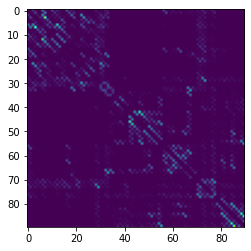

In [2]:
# load connectivity matrices
import pickle
matrices = pickle.load( open( "data/matrices.p", "rb" ) )
print(matrices.shape)
plt.imshow(matrices[1,:,:])

In [3]:
# convert upper triangles of the matrices to feature vectors

# dimensions
n = matrices.shape[0]
m = matrices.shape[1]
D = round(m*(m-1)/2)
print('n={}, D={}'.format(n,D))

# feature matrix
X=np.zeros([n,D])
for i in range(n):
    index=0
    for j in range(m):
        for k in range(j):
            X[i,index]=matrices[i,j,k]
            index=index+1
print(X.shape)

n=433, D=4005
(433, 4005)


In [4]:
# load subject info
subject_info = pd.read_csv('data/subject_info.csv')
X = pd.DataFrame(X)

# Add Age at scan to features matrix, therefore number of features will be 4006
X = pd.concat([X, subject_info['age']], axis=1)
subject_info


,age,prematurity
0,41,0
1,41,0
2,40,0
3,41,0
4,41,0
...,...,...
428,44,0
429,41,0
430,44,0
431,42,0


In [5]:
# load gray matter region descriptions - you will need this in Part B
# don't worry about the labels for now - there are here only to help you understand the dataset
label_names = pd.read_csv('data/label_names.csv')
label_names

,Label,Region name,Region description
0,1.0,Precentral_L,Precental gyrus
1,2.0,Precentral_R,Precental gyrus
2,3.0,Frontal_Sup_L,"Superior frontal gyrus, dorsolateral"
3,4.0,Frontal_Sup_R,"Superior frontal gyrus, dorsolateral"
4,5.0,Frontal_Sup_Orb_L,"Superior frontal gyrus, orbital part"
...,...,...,...
85,86.0,Temporal_Mid_R,Middle temporal gyrus
86,87.0,Temporal_Pole_Mid_L,Temporal pole: middle temporal gyrus
87,88.0,Temporal_Pole_Mid_R,Temporal pole: middle temporal gyrus
88,89.0,Temporal_Inf_L,Inferior temporal gyrus


## Preprocessing

**4 marks**

**Task 1:** Prepare prepare your data for training machine learning models. To do that
* Normalise feature matrix `X` using `StandardScaler`
* Extract label vector `y` that represents prematurity

In [6]:
# Your preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = subject_info['prematurity']


/Users/Martin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/Martin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


## Analysis of the dataset
**14 marks**

**Task 2.1:** Investigate important characeristics of the dataset to understand the problem. To do that
* print the number of features and samples
* print out the number of all babies, term and preterm babies, and calculate the proportion of preterm babies.

Number of features in the dataset: 4006
Number of samples in the dataset: 433


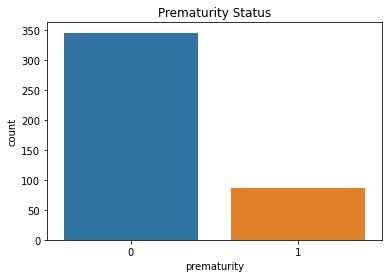

NUMBER OF TOTAL BABIES: 433
PREMATURITY STATUS:
    Term-born: 346
    Premature: 87 

Therefore 20.09% are preterm/premature babies


In [7]:
# Print characteristics of the data

print(f'Number of features in the dataset: {X.shape[1]}')
print(f'Number of samples in the dataset: {X.shape[0]}')

# Plot
sns.countplot(x=y)
plt.title('Prematurity Status')
plt.show()
print(f'NUMBER OF TOTAL BABIES: {len(y)}')
print('PREMATURITY STATUS:')
print(f'    Term-born: {y.value_counts().iloc[0]}')
print(f'    Premature: {y.value_counts().iloc[1]} \n')
print(f'Therefore {round(y.value_counts().iloc[1]*100/len(y), 2)}% are preterm/premature babies')


**Task 2.2:** Describe two challenges of succesfully fitting a classifier to this dataset [max 100 words]:
* **Challenge 1:** Imbalanced dataset. There are way more term-born babies than premature, therefore accuracy by itself is not a good metric to measure a model's performance.
* **Challenge 2:** There are over 4000 features in the dataset, so there is a high risk of overfitting the model.

**Task 2.3:** Visualise the dataset. To be able to do that, reduce the feature matrix using PCA. 

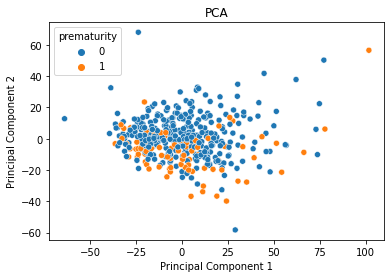

In [8]:
# visualise the dataset using PCA

from sklearn.decomposition import PCA

# PCA with 2 principal components
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

# Plot
sns.scatterplot(data=pca_results, x=pca_results[:,0], y=pca_results[:,1], hue=y)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.show()

## Evaluation framework

**25 marks**

**Task 3.1:** Create the test set for final evaluation of your classifier. Use 20% of the data and stratify the split by the label. Verify that the stratification has worked.

In [9]:
# Training and Test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=101)

# Stratification Verification
print(f'Preborn (training set): {np.count_nonzero(y_train == 1)}')
print(f'Preborn (test set): {np.count_nonzero(y_test == 1)}')
print(f'20% of {y.value_counts().iloc[1]} is {np.count_nonzero(y_test == 1)} (rounded)')


Preborn (training set): 70
Preborn (test set): 17
20% of 87 is 17 (rounded)


**Task 3.2:** Using PCA transformed features, display training and test set.

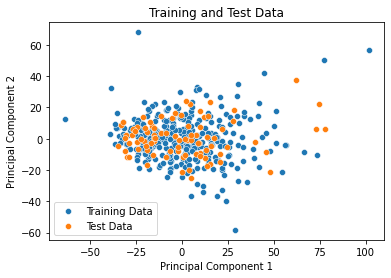

In [10]:
# Visualise Training and Test set

X_train_transform = pca.transform(X_train)
X_test_transform = pca.transform(X_test)

# Plot
sns.scatterplot(data=X_train_transform, x=X_train_transform[:,0], y=X_train_transform[:,1], label='Training Data')
sns.scatterplot(data=X_test_transform, x=X_test_transform[:,0], y=X_test_transform[:,1], label='Test Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Training and Test Data')
plt.show()

**Task 3.3:** Write function `evaluationTrain(model,X,y)` that will
* fit the model
* print out the accuracy calculated on the training set

In [11]:
# evaluationTrain

def evaluationTrain(model, X_train, y_train):
    
    '''* Fit the model
    * Print out the accuracy calculated on the training set'''
    
    model.fit(X_train, y_train)
    print(f'Accuracy calculated on training set: {model.score(X_train, y_train)}')
    return model
    

**Task 3.4:** Write function `evaluationCV(model,X,y)` that will calculate the following measures using cross-validation:
* Accuracy
* Sensitivity
* Specificity
* Mean Recall

In [14]:
# evaluationCV

from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score

def evaluationCV(model,X,y):
    '''calculate the following measures using cross-validation:
    * Accuracy
    * Sensitivity
    * Specificity
    * Mean Recall'''
    
    # accuracy
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    y_pred = cross_val_predict(model, X, y)
    
    # Sensitivity, specificity, and mean recall
    sensitivity = recall_score(y,y_pred,pos_label = 1)
    specificity = recall_score(y,y_pred,pos_label = 0)
    mean_recall = recall_score(y,y_pred,average='macro')
    
    # Print
    print('Accuracy: ', round(scores.mean(),2))
    print('Sensitivity: ',round(sensitivity,2))
    print('Specificity: ',round(specificity,2))
    print('Mean Recall: ',round(mean_recall,2))

**Task 3.5:** Write function `evaluationTest(model,X,y)` that will calculate the following measures on test set:
* Accuracy
* Sensitivity
* Specificity
* Mean Recall

In [15]:
# evaluationTest

def evaluationTest(model,X_test,y_test):
    '''calculate the following measures on test set:
    * Accuracy
    * Sensitivity
    * Specificity
    * Mean Recall'''
    
    y_pred = model.predict(X_test)

    # Sensitivity, specificity, and mean recall
    sensitivity = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    mean_recall = recall_score(y_test, y_pred, average='macro')
    
    # Print
    print(f'Accuracy: {round(model.score(X_test, y_test), 2)}')
    print(f'Sensitivity: {round(sensitivity, 2)}')
    print(f'Specificity: {round(specificity, 2)}')
    print(f'Mean Recall: {round(mean_recall, 2)}')

## Train a classifier

**42 marks**

**Task 4.1:** Select a standard logistic regression classifier. Train and tune it using the correct set of data. Print out the tuned parameters and the best cross-validated score.

In [12]:
# Fit logistic regression classifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create LR model and find an tune C parameter
model = LogisticRegression(class_weight='balanced')
param = {'C':np.logspace(-3,3,13)}
g = GridSearchCV(model,param,cv=5, scoring='f1')

# Train model and save best estimator
evaluationTrain(g, X_train, y_train)
LR_model = g.best_estimator_

# print results
print('Best CV accuracy: ',round(g.best_score_,2))
print('Best C: ',round(g.best_estimator_.C,2))

Accuracy calculated on training set: 1.0
Best CV accuracy:  0.81
Best C:  1000.0


**Task 4.2:** Evaluate the fitted model on the whole training set and using cross-validataion.

In [16]:
# evaluate

evaluationCV(LR_model, X_train, y_train)


Accuracy:  0.93
Sensitivity:  0.73
Specificity:  0.98
Mean Recall:  0.86


**Task 4.3:** Interpret the performance results [max 50 words].

It can be seen that the model is overfitted, when calculating accuracy on the whole training set the result is 1, however, when doing the cross-validation is 0.93. Furthermore, sensitivity is not as good as specificity, meaning that the proportion of correctly classified negative samples is not as good as the one of positive samples.



**Task 4.4:** Design a solution to address the problem with the classifier performance that you identified.

In [21]:
# Updated classifier

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[('pca', PCA()), ('sgdc', SGDClassifier(max_iter=150000, class_weight='balanced'))])
param_grid = {'pca__n_components': [30, 35, 40, 45],
              'sgdc__penalty': ['l2', 'l1'],
              'sgdc__alpha': np.logspace(-3, 3, 7)}

g = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5))
evaluationTrain(g, X_train, y_train)
SGD_model = g.best_estimator_
print('Best CV accuracy: ',round(g.best_score_,2))
g.best_params_


Accuracy calculated on training set: 0.7840909090909091
Best CV accuracy:  0.75


{'pca__n_components': 45, 'sgdc__alpha': 1.0, 'sgdc__penalty': 'l2'}

**Task 4.5:** Evaluate performance of your updated model on the whole training set and using cross-validation. 

In [23]:
# evaluate

evaluationCV(SGD_model, X_train, y_train)


Accuracy:  0.81
Sensitivity:  0.94
Specificity:  0.71
Mean Recall:  0.82


**Task 4.6:** Explain your solution and comment on whether the performance was improved [max 50 words].

For this solution a pipeline and a GridsearchCV were used to optimise a SGDClassifier. PCA was used as well to reduce number of features. And this time the model does not look overfitted as the Accuracy on the training set is closer to the CV accuracy. In the training set now sensitivity is a bit higher than specificity.

**Task 4.7:** Describe how your classifier addresses the challenges you identified: [maximum 100 words]
* **Challenge 1:** For the imbalanced dataset problem the paramter 'class_weight' was tuned to 'balanced' to give more weight to the label (pre-term) with less frequency. Also, when performing CV a estratified K-fold was used to make sure to have the same proportion of labels in each fold.
* **Challenge 2:** To reduce overfitting due to a high number of features, PCA descomposition was used to reduce the number of features, to find the optimal number of features needed, the number of components was optimised using a GridsearchCV.

## Results
**15 marks**

**Task 5.1:** Evaluate performance of both classifiers on the test set.

In [24]:
# evaluate classifier 1
evaluationTest(LR_model, X_test, y_test)

Accuracy: 0.92
Sensitivity: 0.71
Specificity: 0.97
Mean Recall: 0.84


In [25]:
# evaluate classifier 2
evaluationTest(SGD_model, X_test, y_test)

Accuracy: 0.83
Sensitivity: 0.82
Specificity: 0.83
Mean Recall: 0.83


**Task 5.2:** Describe how your conclusions have changed (or been reinforced) once you analysed performance on the test set. Reason why there might be a different conclusion when performance is measured on test set compared to cross-validation. [Max 100 words]

In the case of the first model (LR), accuracy decreases as the model was overfitted to the training set, however, a high accuracy is still obtained but the reason for this occuring is that the dataset is imbalanced. In the second classifier (SGDClassifier) there is less overfitting, however, there is some difference when comparing performance measured on the test-set with cross-validation. One reasons for this could be that there is not enough data in the test set (only 17 pre-term babies) due to imbalanced dataset causing to obtain results that are not 100% significant. In order to improve training and performance more data from more samples could be collected and also other classifiers involving other techniques like deep learning could be tried.

**Task 5.3:** Visualise the results using PCA. To do that, plot the data with their true labels in one plot and the predicted labels in the other. Do that for both training set and test set. Select the best performing classifier to do that.

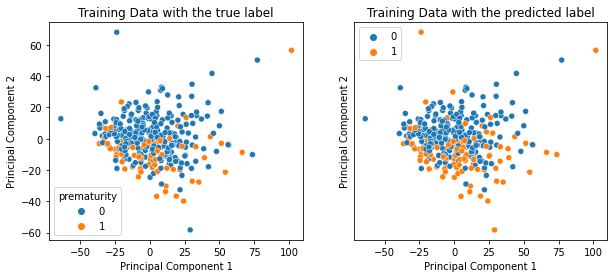

In [26]:
# plot 

# Create Figure with 2 axes
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1,2)

# Axis 1: Training Data with true label
ax1 = plt.subplot(gs[0,0])
sns.scatterplot(x=X_train_transform[:,0], y=X_train_transform[:,1], hue=y_train)
plt.title('Training Data with the true label')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')

# Axis 2: Training Data with predicted label
ax2 = plt.subplot(gs[0,1])
sns.scatterplot(x=X_train_transform[:,0], y=X_train_transform[:,1], hue=SGD_model.predict(X_train))
plt.title('Training Data with the predicted label')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_yticks([], [])
plt.show()


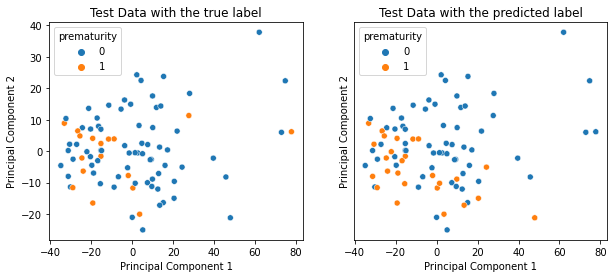

In [27]:
# Create Figure with 2 axes
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1,2)

# Axis 1: Test Data with true label
ax1 = plt.subplot(gs[0,0])
sns.scatterplot(x=X_test_transform[:,0], y=X_test_transform[:,1], hue=y_test)
plt.title('Test Data with the true label')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')

# Axis 2: Test Data with predicted label
ax2 = plt.subplot(gs[0,1])
sns.scatterplot(x=X_test_transform[:,0], y=X_test_transform[:,1], hue=SGD_model.predict(X_test))
plt.title('Test Data with the predicted label')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_yticks([], [])
ax2.legend(title='prematurity')
plt.show()